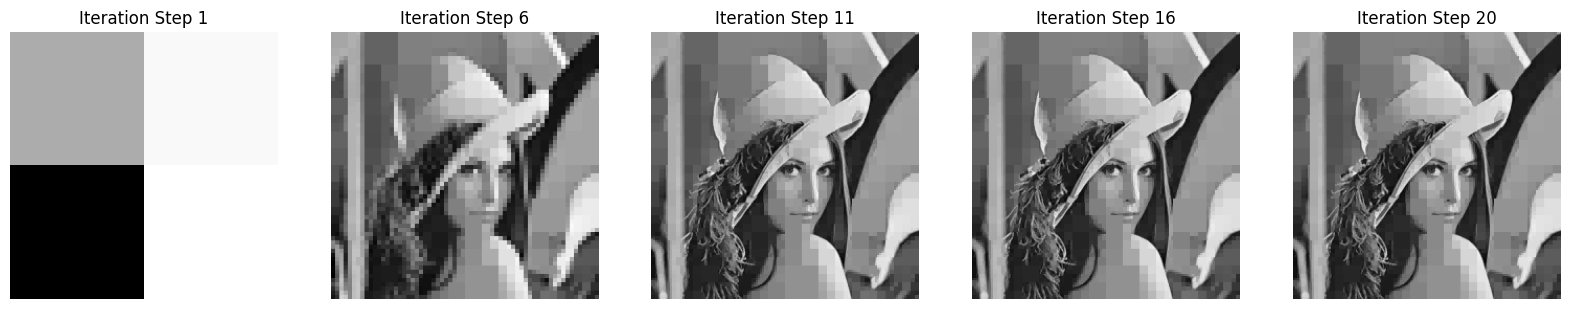

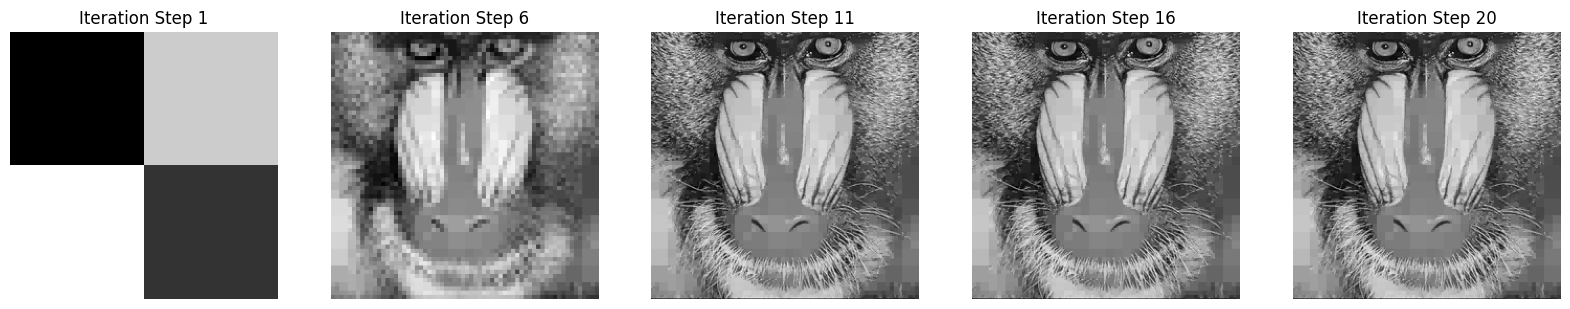

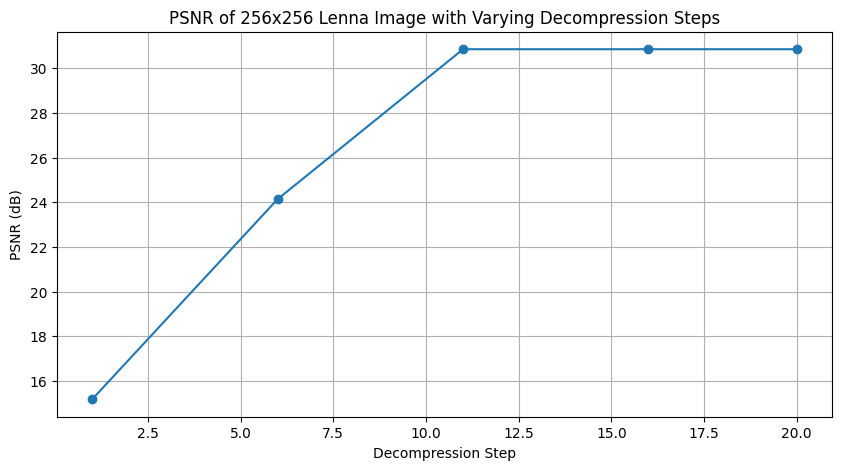

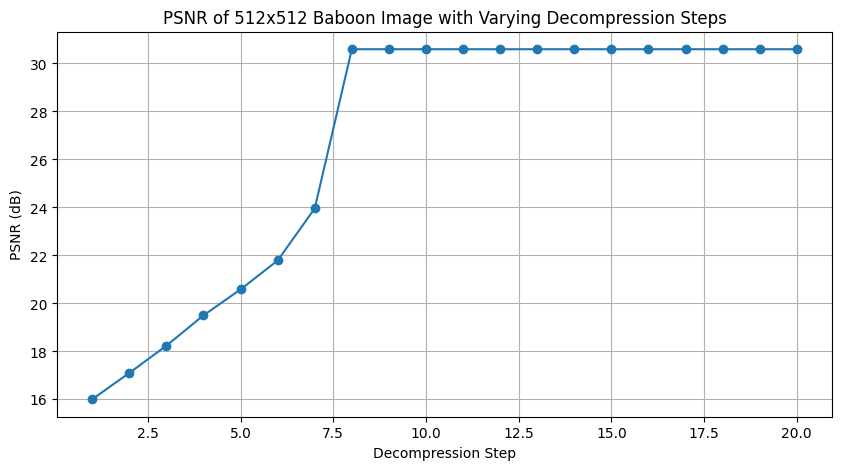

In [19]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

MAX_DEPTH = 20
DETAIL_THRESHOLD = 13
SIZE_MULT = 1

def average_colour(image):
    # convert image to np array
    image_arr = np.asarray(image)

    # get average of whole image
    avg_color = np.average(image_arr)

    return int(avg_color)

def weighted_average(hist):
    total = sum(hist)
    error = value = 0

    if total > 0:
        value = sum(i * x for i, x in enumerate(hist)) / total
        error = sum(x * (value - i) ** 2 for i, x in enumerate(hist)) / total
        error = error ** 0.5

    return error

def get_detail(hist):
    return weighted_average(hist)

class Quadrant():
    def __init__(self, image, bbox, iteration_step):
        self.bbox = bbox
        self.iteration_step = iteration_step
        self.children = None
        self.leaf = False

        # crop image to quadrant size
        image = image.crop(bbox)
        hist = image.histogram()

        self.detail = get_detail(hist)
        self.colour = average_colour(image)

    def split_quadrant(self, image):
        left, top, width, height = self.bbox

        # get the middle coords of bbox
        middle_x = left + (width - left) / 2
        middle_y = top + (height - top) / 2

        # split root quadrant into 4 new quadrants
        upper_left = Quadrant(image, (left, top, middle_x, middle_y), self.iteration_step+1)
        upper_right = Quadrant(image, (middle_x, top, width, middle_y), self.iteration_step+1)
        bottom_left = Quadrant(image, (left, middle_y, middle_x, height), self.iteration_step+1)
        bottom_right = Quadrant(image, (middle_x, middle_y, width, height), self.iteration_step+1)

        # add new quadrants to root children
        self.children = [upper_left, upper_right, bottom_left, bottom_right]

class QuadTree():
    def __init__(self, image):
        self.width, self.height = image.size

        # keep track of max depth achieved by recursion
        self.max_iteration_step = 0

        # start compression
        self.start(image)

    def start(self, image):
        # create initial root
        self.root = Quadrant(image, image.getbbox(), 0)

        # build quadtree
        self.build(self.root, image)

    def build(self, root, image):
        if root.iteration_step >= MAX_DEPTH or root.detail <= DETAIL_THRESHOLD:
            if root.iteration_step > self.max_iteration_step:
                self.max_iteration_step = root.iteration_step

            # assign quadrant to leaf and stop recursing
            root.leaf = True
            return

        # split quadrant if there is too much detail
        root.split_quadrant(image)

        for children in root.children:
            self.build(children, image)

    def create_image(self, custom_iteration_step, show_lines=False):
        # create blank image canvas
        image = Image.new('L', (self.width, self.height))
        draw = ImageDraw.Draw(image)
        draw.rectangle((0, 0, self.width, self.height), 0)

        leaf_quadrants = self.get_leaf_quadrants(custom_iteration_step)

        # draw rectangle size of quadrant for each leaf quadrant
        for quadrant in leaf_quadrants:
            if show_lines:
                draw.rectangle(quadrant.bbox, quadrant.colour, outline=255)
            else:
                draw.rectangle(quadrant.bbox, quadrant.colour)

        return image

    def get_leaf_quadrants(self, iteration_step):
        # Ensure iteration_step does not exceed max depth of the tree
        if iteration_step > self.max_iteration_step:
            iteration_step = self.max_iteration_step

        quadrants = []

        # search recursively down the quadtree
        self.recursive_search(self.root, iteration_step, quadrants.append)

        return quadrants

    def recursive_search(self, quadrant, max_iteration_step, append_leaf):
        # append if quadrant is a leaf
        if quadrant.leaf == True or quadrant.iteration_step == max_iteration_step:
            append_leaf(quadrant)

        # otherwise keep recursing
        elif quadrant.children != None:
            for child in quadrant.children:
                self.recursive_search(child, max_iteration_step, append_leaf)

if __name__ == '__main__':
    # Load and convert Lenna image to grayscale
    lenna_image_path = "lena15.jpg"
    lenna_image = Image.open(lenna_image_path).convert('L')
    lenna_image = lenna_image.resize((256, 256))
    baboon_image_path="baboon.png"
    baboon_image=Image.open(baboon_image_path).convert('L')
    baboon_image=baboon_image.resize((256,256))

    # Create quadtree for Lenna image
    lenna_quadtree = QuadTree(lenna_image)
    baboon_quadtree=QuadTree(baboon_image)

    # Create and display images with steps 1, 6, 11, 16, 20
    lenna_steps = [1, 6, 11, 16, 20]
    lenna_images = []
    baboon_images=[]

    for iteration_step in lenna_steps:
        decompressed_image = lenna_quadtree.create_image(iteration_step, show_lines=False)
        lenna_images.append(decompressed_image)
        decompressed_imageb=baboon_quadtree.create_image(iteration_step, show_lines=False)
        baboon_images.append(decompressed_imageb)

    # Display Lenna images
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for ax, iteration_step, img in zip(axs, lenna_steps, lenna_images):
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Iteration Step {iteration_step}')
        ax.axis('off')

    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for ax, iteration_step, img in zip(axs, lenna_steps, baboon_images):
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Iteration Step {iteration_step}')
        ax.axis('off')

    plt.show()

    # Calculate and plot PSNR values for Lenna image
    lenna_psnr_values = []
    for iteration_step in lenna_steps:
        decompressed_image = lenna_quadtree.create_image(iteration_step, show_lines=False)
        decompressed_image_np = np.array(decompressed_image)
        original_image_np = np.array(lenna_image)
        psnr_value = psnr(original_image_np, decompressed_image_np, data_range=255)
        lenna_psnr_values.append(psnr_value)

    # Plot PSNR values for Lenna image
    plt.figure(figsize=(10, 5))
    plt.plot(lenna_steps, lenna_psnr_values, marker='o')
    plt.title('PSNR of 256x256 Lenna Image with Varying Decompression Steps')
    plt.xlabel('Decompression Step')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    plt.show()

    # Load and convert Baboon image to grayscale
    baboon_image_path = "baboon.png"
    baboon_image = Image.open(baboon_image_path).convert('L')
    baboon_image = baboon_image.resize((256, 256))

    # Create quadtree for Baboon image
    baboon_quadtree = QuadTree(baboon_image)

    # Create and store PSNR values for Baboon image with iteration steps 1 to 20
    baboon_steps = list(range(1, 21))
    psnr_values = []

    for iteration_step in baboon_steps:
        decompressed_image = baboon_quadtree.create_image(iteration_step, show_lines=False)
        decompressed_image_np = np.array(decompressed_image)
        original_image_np = np.array(baboon_image)
        psnr_value = psnr(original_image_np, decompressed_image_np, data_range=255)
        psnr_values.append(psnr_value)

    # Plot PSNR values for Baboon image
    plt.figure(figsize=(10, 5))
    plt.plot(baboon_steps, psnr_values, marker='o')
    plt.title('PSNR of 512x512 Baboon Image with Varying Decompression Steps')
    plt.xlabel('Decompression Step')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    plt.show()
